In [1]:

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
import os

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore

Helper imported succesfully


In [2]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [ ]:
# Resolve project paths (repo root assumed to be parent of this script's CWD)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

figures_dir = os.path.join(project_root, 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Local imports from the project
import models  # type: ignore
import helper  # type: ignore

# -----------------------------
# Load matrices, model, scalers
# -----------------------------
matrix_C = False

A = np.load("../data/A_C_False.npy")
B = np.load("../data/B_C_False.npy")
C = np.load("../data/C_C_False.npy")

nz, nu = B.shape
ny = C.shape[0]

# disturbance matrix F and dimension nd
F = np.eye(ny)
nd = F.shape[1]

# Block-diagonalize A using helper
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print('Close to block diagonal?', np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print('Backtransformation equals original A?', np.allclose(A, A_backtransformed, atol=1e-6))

# Apply similarity transform to A, B, C
A = A_block
B = inv(T_real) @ B
C = C @ T_real

# -----------------------------
# Build Koopman model components
# -----------------------------
cons = 3
layers = [6*cons,12*cons,18*cons]
layers_dec  = [18*cons,12*cons,6*cons]

# Output encoder f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# Input encoder f_u representing B in linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# State decoder f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(
        nz,
        ny,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ELU,
        hsizes=layers_dec,
    )
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# Linear map K for latent dynamics
K = torch.nn.Linear(nz, nz, bias=False)

# Symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
loss = PenaltyLoss([], constraints=[])
problem = Problem(nodes, loss)

problem.load_state_dict(
    torch.load(os.path.join(project_root, 'data', f'model_C_{matrix_C}.pth')),
    strict=False,
)

# -----------------------------
# Load scalers and plant model
# -----------------------------
scaler = joblib.load(os.path.join(project_root, 'data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join(project_root, 'data', 'scalerU.pkl'))


Models imported succesfully
Close to block diagonal? True
Backtransformation equals original A? True


In [4]:
scaler.mean_

array([48.83101173, 70.21004399, 50.1579912 ])

In [5]:
# # Resample A and B from Ts=1 to Ts=10 seconds
# Ts_old = 1.0    # original timestep in seconds
# Ts_new = 10.0   # desired timestep in seconds

# # Assume system is already in discrete time with Ts=1.0
# # To resample A, B to Ts=10.0, use the method for "resampling" discrete systems:
# #   A_10 = A_1^10
# #   B_10 = sum_{i=0}^{9} A_1^i @ B_1

# # A_10 = np.linalg.matrix_power(A, int(Ts_new / Ts_old))

# # sum_term = np.zeros_like(B)
# # A_power = np.eye(A.shape[0])
# # for i in range(int(Ts_new / Ts_old)):
# #     sum_term += A_power @ B
# #     A_power = A @ A_power
# # B_10 = sum_term

# # A = A_10
# # B = B_10
# import scipy.linalg as la

# # Convert to continuous through matrix log
# Ac = la.logm(A) / Ts_old
# Bc = np.linalg.solve(Ac, (A - np.eye(A.shape[0]))) @ B

# # Re-discretize at Ts_new
# A = A_10 = la.expm(Ac * Ts_new)
# B = B_10 = np.linalg.solve(Ac, (A_10 - np.eye(A.shape[0]))) @ Bc

# A = np.real(A)
# B = np.real(B)

# np.save(f"../data/A_C_{matrix_C}_Ts.npy", A)
# np.save(f"../data/B_C_{matrix_C}_Ts.npy", B)


In [6]:
# Plant model: use full nonlinear CSTR series with recycle for simulation

# Helper conversion utilities
def get_x(y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({'Y0': torch.from_numpy(y).float()})
    return x['x'].detach().numpy().reshape(1, -1).T

def get_y(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy().reshape(1, -1)

# -----------------------------
# Observer - Kalman filter setup
# -----------------------------
loaded_setup = joblib.load(os.path.join(os.getcwd(), 'sim_setup.pkl'))

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

z_est_ = np.hstack(((inv(T_real) @ get_x(y_start)).T, np.zeros((1, nd))))
P0 = np.eye(nz + nd)*loaded_setup['P0']
Q = np.block([
    [np.eye(nz) * loaded_setup['Q'],  np.zeros((nz, nd))],   # Trust state model
    [np.zeros((nd, nz)), np.eye(nd) * 1.0]      # Disturbance adapts fast
])
R = np.eye(ny)*loaded_setup['R']  # measurement noise

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

EKF = helper.EKF(A_, B_, z_est_, P0, problem, Q, R, 3, T_real)
# EKF = helper.EKF_C(A_, B_, C, z_est_, P0, problem, Q, Rm, 2, T_real)

# -----------------------------
# Target calculation
# -----------------------------
target_estimation = helper.TaylorTargetEstimation(A, B)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_est_[0, :nz]).float(),
) @ T_real

z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_est_[0, :nz]), z_est_[0, :nz], J
)
print(target_estimation.te.status)
print('Optimal y:', scaler.inverse_transform(y_s.reshape(1, -1)))
print('Desired y:', scaler.inverse_transform(y_setpoint.reshape(1, -1)))
print('Optimal u:', scalerU.inverse_transform(target_estimation.u_s.value.reshape(1, -1)))
z_ref = z_s


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05
optimal
Optimal y: [[53.15139782 69.29679784 52.66469427]]
Desired y: [[52.738903 69.24475  53.087387]]
Optimal u: [[99.93143603 99.99999992 40.39095435]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [7]:

# -----------------------------
# MPC problem formulation
# -----------------------------
Qy = loaded_setup['Qy']
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_est_[0, :nz]).float(),
) @ T_real
Qz = J.T @ Qy @ J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

mpc = helper.TaylorMPC(A, B)
mpc.build_problem(Qz_psd)
u_opt = mpc.get_u_optimal(
    z_est_[0, :nz], z_est_[:, nz:], u_previous, z_ref, get_y(T_real @ z_s), z_s, J,Qz_psd
)
print(u_opt)
print(mpc.mpc.status)


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[0.73240557 0.87087853 1.03645885]
optimal


In [8]:
baseline_inference.get_x(y_start)

In [9]:

# -----------------------------
# Closed-loop simulation
# -----------------------------
from tqdm import tqdm

sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
y_pred = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time + 1))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_sim = np.zeros((nu, sim_time + 1))

total_time_target = 0.0
total_time_mpc = 0.0

start_time_target = time.time()
z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_s), z_s, J
)
end_time_target = time.time()
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time + 1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]

for k in tqdm(range(sim_time), desc="Closed-loop simulation", ncols=80):
    y_setpoint = loaded_setup['reference'][:, k]
    idx_prev = max(k - 1, 0)

    # target update (T2): linearize at previous target zs_sim[:, k]
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real @ z_sim[:nz, k]).float(),
    ) @ T_real
    start_time_target = time.time()
    zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], 
        y_setpoint, 
        get_y(T_real @ zs_sim[:, idx_prev]), 
        zs_sim[:, idx_prev], 
        J
    )
    y_pred[:,k] = J@z_sim[:nz,k]
    end_time_target = time.time()
    total_time_target += end_time_target - start_time_target

    # T2/D2: for MPC, linearize at the previous target zs_sim[:, k-1] (use k=0 fallback)
    # J_prev = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    # ) @ T_real
    # J = J_prev

    # if k > 0:
    Qz = J.T @ Qy @ J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    # mpc.build_problem(Qz_psd)

    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(
        z_sim[:nz, k],
        z_sim[nz:, k],
        u_prev,
        zs_sim[:, k],
        get_y(T_real @ zs_sim[:, idx_prev]),
        zs_sim[:, idx_prev],
        J,
        Qz_psd
    )
    end_time_mpc = time.time()
    total_time_mpc += end_time_mpc - start_time_mpc

    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # simulate plant in physical space
    # for i in range(int(10-1)):
    #     baseline_inference.y_plus(u_sim[:, k])
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    y_sim_descaled[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]

    # state estimation
    z_sim[:, k + 1] = EKF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()

    u_prev = u_sim[:, k]

print(f'Total time spent in target estimation: {total_time_target:.4f} seconds')
print(f'Total time spent in MPC solve: {total_time_mpc:.4f} seconds')


Closed-loop simulation:   0%|                           | 0/500 [00:00<?, ?it/s]

Closed-loop simulation: 100%|█████████████████| 500/500 [01:40<00:00,  4.96it/s]

Total time spent in target estimation: 2.1296 seconds
Total time spent in MPC solve: 97.0684 seconds


In [10]:
z_sim[:, k].shape

(15,)

Closed-loop objective function value: 26.07630398560177
  - State tracking term: 23.20406801613874
  - Input increment term: 2.872235969463056


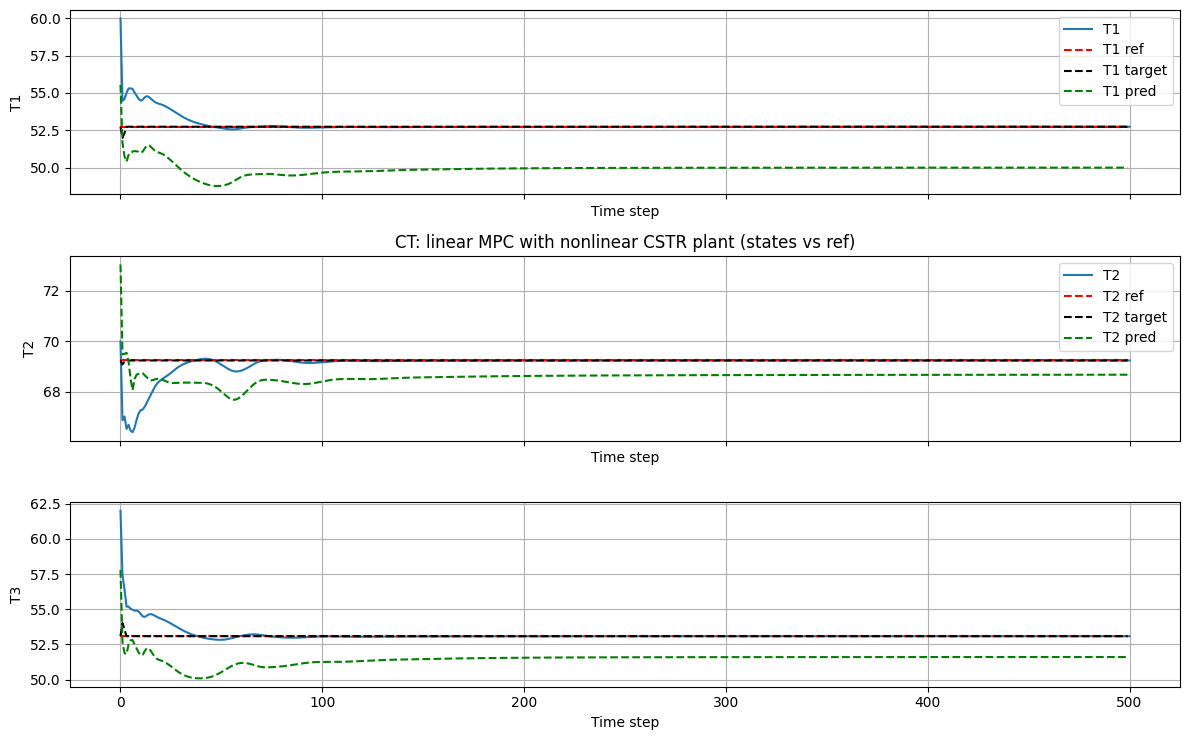

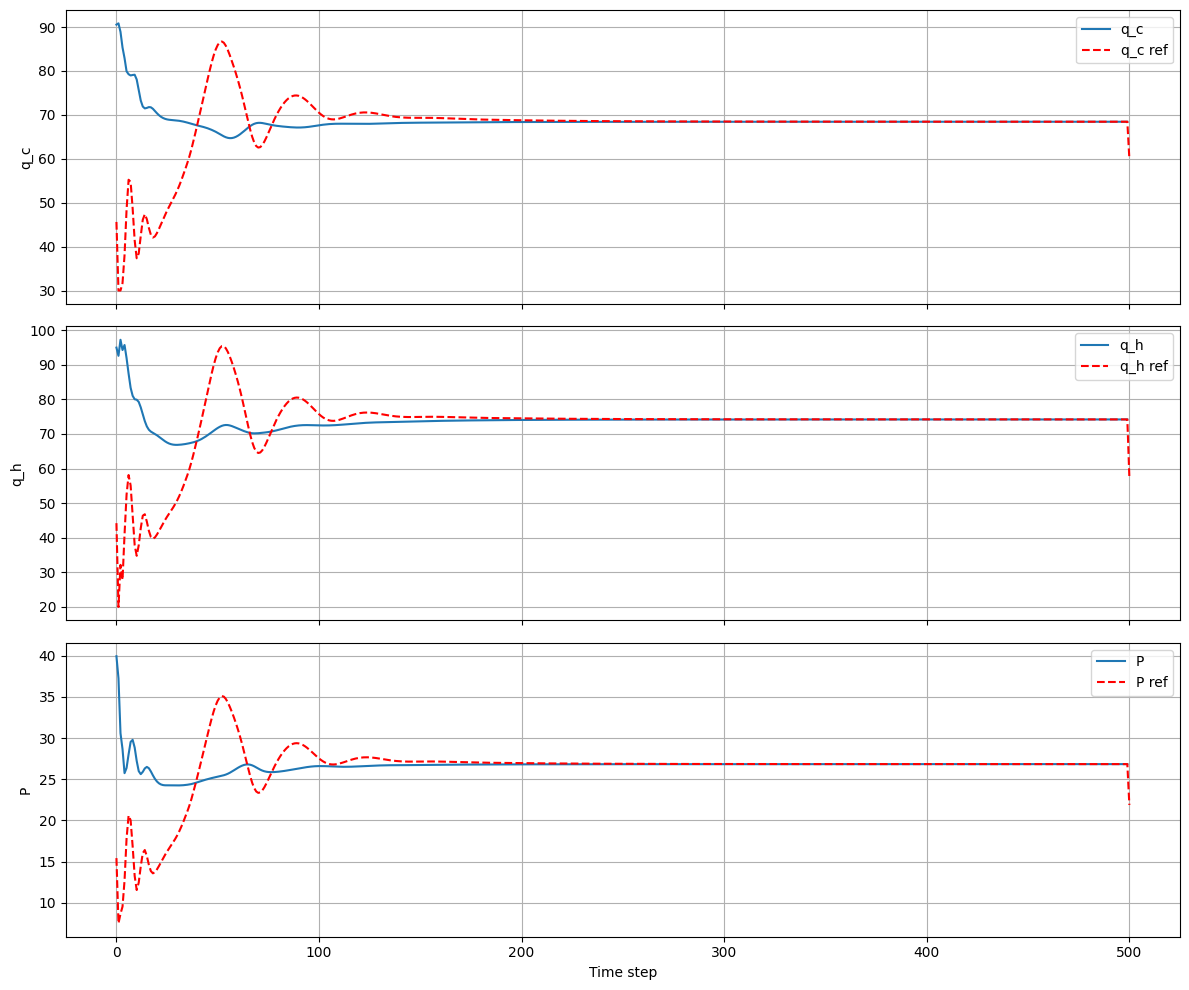

In [11]:
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    y_ref_k = reference[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
names = ['T1', 'T2', 'T3']
n_steps = sim_time
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
us_sim_ns = scalerU.inverse_transform(us_sim.T).T
y_pred_ns = scaler.inverse_transform(y_pred.T).T

fig, axs = plt.subplots(min(8, ny), 1, figsize=(12, 2.5*min(8, ny)), sharex=True)
if min(8, ny) == 1:
    axs = [axs]  # ensure axs is iterable even for 1 plot

for i in range(min(8, ny)):
    ax = axs[i]
    ax.plot(y_sim_descaled[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
        ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    ax.plot(y_pred_ns[i, :n_steps], 'g--', label=f'{names[i]} pred')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0, 1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'q_h', 'P']
for i in range(3):
    axs[i].plot(u_sim_descaled[i, :], label=input_names[i])
    axs[i].plot(us_sim_ns[i, :], 'r--', label=f"{input_names[i]} ref")
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#1671

In [12]:
sum(u_sim_descaled[2,:])

np.float64(13328.188285527138)

In [13]:
sum(sum(z_sim[nz:,:]))

np.float64(-16.01553000821792)

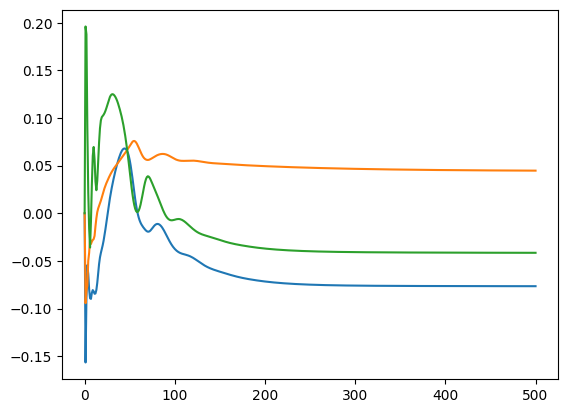

In [14]:
plt.plot(z_sim[nz:,:].T)

In [15]:
z_sim[nz:,-1]

array([-0.07656058,  0.0447596 , -0.04150381])

In [16]:
ys_sim_ns[:,-2]

array([52.73890327, 69.24475002, 53.08738669])